In [274]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import sys
!{sys.executable} -m pip install xlrd

In [275]:
def init_restriction_df(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

restrictions_df = init_restriction_df(r'csv_files/updated_restrictions.csv.zip', ["STATE"])
restrictions_df = restrictions_df[restrictions_df.index.notnull()]
restrictions_df.replace("0", np.nan, inplace=True)
restrictions_df


,POSTCODE,FIPS,STEMERG,STEMERGEND,STEMERG2,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,STAYHOME,...,MINWAGEMAR2019,MINWAGEJUL2019,MINWAGEOCT2019,MINWAGEJAN2020,MINWAGEJUL2020,MINWAGESEP2020,MINWAGEOCT2020,TIPMINWAGE2020,MINWAGE2021,SMALLBUSMINWAGE
STATE,,,,,,,,,,,,,,,,,,,,,
State,State Abbreviation,FIPS Code,State of emergency issued,State of emergency lifted,State of emergency reinstated,Date closed K-12 public schools,Closed day cares,Reopen day cares,Date banned visitors to nursing homes,Stay at home/ shelter in place,...,Mar 29 2019 Minimum Wage,Jul 1 2019 Minimum Wage,Oct 1 2019 Minimum Wage,Jan 1 2020 Minimum Wage,Jul 1 2020 Minimum Wage,Sep 1 2020 Minimum Wage,Oct 1 2020 Minimum Wage,2020 Minimum Wage for Tipped Workers,2021 Minimum Wage,Different Minimum Wage for Smaller Businesses
category,NaN,NaN,state_of_emergency,state_of_emergency,state_of_emergency,physical_distance_closure,physical_distance_closure,Reopening,physical_distance_closure,shelter,...,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage,minimum_wage
type,note,note,start,end,start,start,start,end,start,start,...,quantity,quantity,quantity,quantity,quantity,quantity,quantity,quantity,quantity,attribute
unit,text,attribute,date,date,date,date,date,date,date,date,...,dollars,dollars,dollars,dollars,dollars,dollars,dollars,dollars,dollars,flag
Alabama,AL,1,13/03/2020,06/07/2021,13/08/2021,20/03/2020,20/03/2020,23/05/2020,19/03/2020,04/04/2020,...,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$2.13,$7.25,NaN
Alaska,AK,2,11/03/2020,30/04/2021,NaN,16/03/2020,NaN,NaN,NaN,28/03/2020,...,$9.89,$9.89,$9.89,$10.19,$10.19,$10.19,$10.19,$10.19,$10.34,NaN
Arizona,AZ,4,11/03/2020,NaN,NaN,16/03/2020,NaN,NaN,NaN,31/03/2020,...,$11.00,$11.00,$11.00,$12.00,$12.00,$12.00,$12.00,$9.00,$12.15,NaN
Arkansas,AR,5,11/03/2020,30/05/2021,29/07/2021,17/03/2020,NaN,NaN,13/03/2020,NaN,...,$9.25,$9.25,$9.25,$10.00,$10.00,$10.00,$10.00,$2.63,$11.00,1
California,CA,6,04/03/2020,NaN,NaN,23/03/2020,NaN,NaN,NaN,19/03/2020,...,$12.00,$12.00,$12.00,$13.00,$13.00,$13.00,$13.00,$13.00,$14.00,1


In [276]:
restrictions_df = restrictions_df.loc["California":] 
masks_df = restrictions_df.loc[:, ["FM_ALL", "FM_ALL2", "FM_END", "FM_END2"]] # Here there are more fields that one could look at
day_care_df = restrictions_df.loc[:, ["CLDAYCR", "OPNCLDCR"]] # Dataset don't include school reopening
stay_at_home_df = restrictions_df.loc[:, ["STAYHOME", "END_STHM"]]
close_businesses = restrictions_df.loc[:, ["CLBSNS", "END_BSNS"]]
double_restrictions = restrictions_df.loc[:, ["CLREST", "ENDREST", "CLRST2", "ENDREST2", "CLGYM", "ENDGYM", "CLGYM2", "END_CLGYM2", "CLMOVIE", "END_MOV", "CLMV2", "END_CLMV2", "CLOSEBAR", "END_BRS", "BCLBAR2", "END_BRS2"]]


In [277]:
start_date = "2020-06-04"
end_date = "2022-03-28"

def add_missing_data(df, start, end):
  days_idx = pd.date_range(start=start, end=end, freq="D")
  days_with_missing_data = df.reindex(days_idx, fill_value=0)
  days_with_missing_data.index.names = ['date']
  df = days_with_missing_data.append(df)
  return df

In [307]:
single_restr = restrictions_df.loc[:, ["CLDAYCR", "OPNCLDCR", "STAYHOME", "END_STHM", "CLBSNS", "END_BSNS"]]

single_restrictions = pd.DataFrame({})

for i, j in zip(range(0, len(single_restr.columns), 2), range(1, len(single_restr.columns)+1, 2)):
  start_day = single_restr.columns[i]
  end_day = single_restr.columns[j]
  dates = single_restr.loc["California", [start_day, end_day]]
  
  if (isinstance(dates[0], str) and isinstance(dates[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates[0], dates[1]), 
                    single_restr.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates[0]) # now we will overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]
    single_restrictions = pd.concat([single_restrictions, fill_end], axis=1)
single_restrictions.fillna(0)
single_restrictions.rename(columns={"STAYHOME": "Stay at home order", "CLBSNS": "Closed other non-essential businesses", "CLDAYCR": "Closed day cares"}, inplace=True)
single_restrictions

,Stay at home order,Closed other non-essential businesses
date,,
2020-03-19,1,1
2020-03-20,1,1
2020-03-21,1,1
2020-03-22,1,1
2020-03-23,1,1
...,...,...
2022-03-24,0,0
2022-03-25,0,0
2022-03-26,0,0


In [305]:
double_restrictions_conv = pd.DataFrame({})

for i in range(0, len(double_restrictions.columns), 4):
  start_day_first = double_restrictions.columns[i]
  end_day_first = double_restrictions.columns[i+1]
  start_day_second = double_restrictions.columns[i+2]
  end_day_second = double_restrictions.columns[i+3]
  dates_first = double_restrictions.loc["California", [start_day_first, end_day_first]]
  dates_second = double_restrictions.loc["California", [start_day_second, end_day_second]]
  
  if (isinstance(dates_first[0], str) and isinstance(dates_first[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates_first[0], dates_first[1]), 
                    double_restrictions.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates_first[0]) # now we might overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates_first[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]

    if (isinstance(dates_second[0], str) and isinstance(dates_second[1], str)):
      fill_end.loc[dates_second[0]:dates_second[1], double_restrictions.columns[i]] = 1

    double_restrictions_conv = pd.concat([double_restrictions_conv, fill_end], axis=1)

double_restrictions_conv.fillna(0)
double_restrictions_conv.rename(columns={"CLREST": "Closed restaurants", "CLGYM": "Closed gym", "CLMOVIE": "Closed movie theaters", "CLOSEBAR": "Closed bars"}, inplace=True)
double_restrictions_conv


16


,Closed restaurants,Closed gym,Closed movie theaters,Closed bars
date,,,,
2020-03-16,1,NaN,NaN,1
2020-03-17,1,NaN,NaN,1
2020-03-18,1,NaN,NaN,1
2020-03-19,1,1.0,1.0,1
2020-03-20,1,1.0,1.0,1
...,...,...,...,...
2022-03-24,0,0.0,0.0,0
2022-03-25,0,0.0,0.0,0
2022-03-26,0,0.0,0.0,0


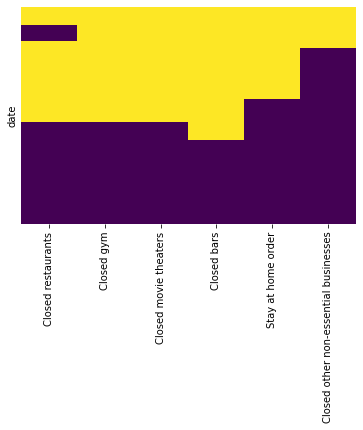

In [306]:

combined_restrictions = pd.concat([double_restrictions_conv, single_restrictions], axis=1)
sns.heatmap(combined_restrictions==1, yticklabels = False, cbar = False, cmap='viridis');
